In [2]:
import pandas
from keras.models import Sequential,Model
from keras import losses
from keras.layers import Dense,Activation,LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils.conv_utils import convert_kernel

from random import seed
from random import choice

%matplotlib inline 
#to plot inline in jupyter notebook  
import numpy as np #for array related 
import scipy.io as spio #to load data 
import cmath #for complex operations
import matplotlib.pyplot as plt #for plotting graphs
import math # for log 
from scipy.signal import hann, welch #for spectral analysis
import keras.backend as K
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.python.eager.context import context, EAGER_MODE, GRAPH_MODE

Using TensorFlow backend.


In [3]:
def plot_spec(spec_input,am_am = False,plot_label = None):
    
    # Spectral analyses of PA input and PA output
    Fs = 7.86e6
    N = np.min(np.array([1024,len(spec_input)]));
    pwin = hann(N);
    f_axis,spec_input_ps = welch(spec_input, Fs, window=pwin, nfft=N, return_onesided=False,scaling = 'spectrum',detrend=False)
    
    spec_input_ps_dB = [ 10*math.log10(abs(spec_input_ps[i])) for i in range(len(spec_input_ps)) ];

    # Plots
    f_axis = [f_axis[i]/1000000 for i in range(len(f_axis))]
    #plt.figure()
    plt.plot(f_axis,spec_input_ps_dB,label = plot_label)
    


In [4]:
#loading data from the file
mat_I = spio.loadmat('qpsk_I_seqLen65472.mat', squeeze_me=True)
mat_Q = spio.loadmat('qpsk_Q_seqLen65472.mat', squeeze_me=True)
data_total_I = mat_I['waveform_I']
data_total_Q = mat_Q['waveform_Q']
data_total = [complex(data_total_I[i],data_total_Q[i]) for i in range(len(data_total_I))]

print('Loaded data')
#input scaling in dB
scale_val = np.max(np.abs(data_total))
data_total = data_total/scale_val
print('Input scaling done')


Loaded data
Input scaling done


In [15]:
def Convert2Feature(input):
	output = [(np.real(i),np.imag(i)) for i in input]
	return np.array(output).reshape(-1,2)

def Convert2Complex(input):
	return np.array([t[0]+1j*t[1] for t in np.array(input)])

def Non_Linearity(input):
	input = np.array([t[0]+1j*t[1] for t in input])
	return Convert2Feature(pa(input))

def pa(input):
    return (input-0.1*input*np.exp(1j*np.pi*0.05/4)*(np.abs(input)**2)+0.005*0.1*input*np.exp(1j*np.pi*0.15/4)*(np.abs(input)**4))

def Generate_Data():
	x_train=np.random.rand(20000)*2-1
	x_train=x_train.reshape(-1,2)
	y_train=Non_Linearity(x_train)
	
	x_test=np.linspace(-1,1,200)
	x_test=x_test.reshape(-1,2)
	y_test=Non_Linearity(x_test)

	return (x_train,y_train,x_test,y_test)

def load_data(x):
    train_len = 8000
    
    y_train = Convert2Feature(pa(x[0:train_len]))
    x_train = Convert2Feature(x[0:train_len])
    
    y_test = Convert2Feature(pa(x[len(x)-5000:]))
    x_test = Convert2Feature(x[len(x)-5000:])
    
    return (x_train,y_train,x_test,y_test)

In [6]:
x_train,y_train,x_test,y_test =  Generate_Data()
np.max(np.abs(Convert2Complex(x_train)))

1.4114888133357408

In [7]:
x_train,y_train,x_test,y_test =  Generate_Data()

model = Sequential()
model.add(Dense(units=2000, input_dim=2))
model.add(Activation('relu'))
model.add(Dense(units=100))
model.add(Activation('tanh'))
model.add(Dense(units=10))
model.add(Activation('linear'))
model.add(Dense(units=2))

model.compile(loss='mean_squared_error',
              optimizer='adam')

model.fit(y_train, x_train, epochs=75, batch_size=100, verbose=1)

#loss_and_metrics = model.evaluate(y_test, x_test, batch_size=100)

Epoch 1/75
10000/10000 [==============================] - 1s 120us/step - loss: 0.0105
Epoch 2/75
10000/10000 [==============================] - 1s 104us/step - loss: 1.4788e-04
Epoch 3/75
10000/10000 [==============================] - 1s 102us/step - loss: 1.0263e-04
Epoch 4/75
10000/10000 [==============================] - 1s 107us/step - loss: 7.4860e-05 1s -
Epoch 5/75
10000/10000 [==============================] - 1s 102us/step - loss: 5.0607e-05
Epoch 6/75
10000/10000 [==============================] - 1s 97us/step - loss: 3.5915e-05
Epoch 7/75
10000/10000 [==============================] - 1s 107us/step - loss: 2.7087e-05
Epoch 8/75
10000/10000 [==============================] - 1s 107us/step - loss: 2.0753e-05
Epoch 9/75
10000/10000 [==============================] - 1s 109us/step - loss: 1.6663e-05
Epoch 10/75
10000/10000 [==============================] - 1s 119us/step - loss: 1.4776e-05
Epoch 11/75
10000/10000 [==============================] - 1s 94us/step - loss: 1.3015e-0

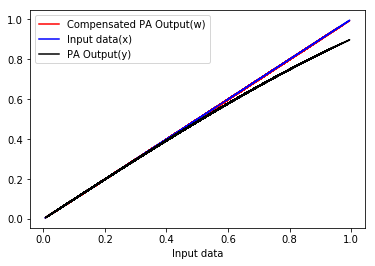

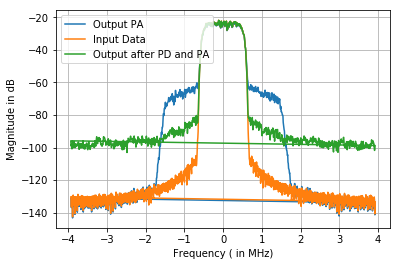

In [10]:
x_train,y_train,x_test,y_test =  load_data(data_total)

classes = model.predict(x_test, batch_size=100)

plt.figure()
plt.plot(np.abs(Convert2Complex(x_test)), np.abs(Convert2Complex(Non_Linearity(classes))),c='r',label = 'Compensated PA Output(w)')
plt.plot(np.abs(Convert2Complex(x_test)),np.abs(Convert2Complex(x_test)),c='b',label = 'Input data(x)')
plt.plot(np.abs(Convert2Complex(x_test)),np.abs(Convert2Complex(y_test)),c='k',label = 'PA Output(y)')
plt.xlabel('Input data')
plt.legend()
plt.show()


plt.figure()
#plt.title('Magnitude spectrum for alpha = '+str(0.1)+' mse = '+str(mse))
#plot_spec(Convert2Complex(x_test),plot_label='Input to PA')
plot_spec((Convert2Complex((y_test))),plot_label='Output PA')

plot_spec(Convert2Complex(x_test),plot_label='Input Data')
plot_spec(pa(Convert2Complex(classes)),plot_label='Output after PD and PA')
plt.ylabel('Magnitude in dB')
plt.xlabel('Frequency ( in MHz)')
plt.legend()
plt.grid(True)
plt.show()

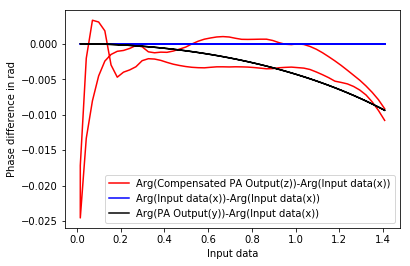

In [17]:
x_train,y_train,x_test,y_test =  Generate_Data()
classes = model.predict(x_test, batch_size=100)

plt.figure()
plt.plot(np.abs(Convert2Complex(x_test[:100])), np.angle(Convert2Complex(Non_Linearity(classes[:100])))-np.angle(Convert2Complex(x_test[:100])),c='r',label = 'Arg(Compensated PA Output(z))-Arg(Input data(x))')
plt.plot(np.abs(Convert2Complex(x_test[:100])),np.angle(Convert2Complex(x_test[:100]))-np.angle(Convert2Complex(x_test[:100])),c='b',label = 'Arg(Input data(x))-Arg(Input data(x))')

plt.plot(np.abs(Convert2Complex(x_test[:100])),np.angle(Convert2Complex(y_test[:100]))-np.angle(Convert2Complex(x_test[:100])),c='k',label = 'Arg(PA Output(y))-Arg(Input data(x))')
plt.xlabel('Input data')
plt.ylabel('Phase difference in rad')
plt.legend()
plt.show()